In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.mixture import GaussianMixture

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
import scipy
import warnings
from math import sqrt, ceil
from collections import Counter
import random

# sklearnのTransformerにしたので、fit_tramsformを呼ぶと外れ値の閾値を返す
class OutlyerModel(BaseEstimator, TransformerMixin):
    def __init__(self, p = 0.99, search_list = list(range(1, 21)), minmax = False, parcentile=0.0001, warning_filter=True):
        random.seed(0)
        self._p = p
        self._search_list = search_list
        self._component_selection_method = self.parcentile
        self._parcentile = parcentile
        self._warning_filter = warning_filter
        if minmax:
            self._component_selection_method = self.minmax


    # 各インデックスのクラス数のBICを計算、もしくはキャッシュから得る
    def get_bic(self, index, x):
        bics = self.bics_
        gmms = self.gmms_
        if (bics[index] is None):
            if self._warning_filter:
                warnings.filterwarnings('ignore')
            gmm = GaussianMixture(n_components=self._search_list[index], reg_covar=1.0e-3)
            gmm = gmm.fit(x)
            bic = gmm.bic(x)
            gmms[index] = gmm
            bics[index] = bic
            self.gmm_fit_count_ += 1
            return bic
        return bics[index]


    def gmm_search(self, x):
        # 最小のBICのクラス数を三分探索をする
        # https://qiita.com/DaikiSuyama/items/84df26daad11cf7da453
        sarch_list_size = len(self._search_list)
        left = 0
        right = sarch_list_size - 1

        self.gmms_ = [None] * sarch_list_size
        self.bics_ = [None] * sarch_list_size

        self.gmm_fit_count_ = 0

        # right=left,left+1,left+2のいずれかになれば探索終了
        while(left + 2 < right):
            centor1 = left + (right - left) // 3
            centor2 = right - (right - left) // 3

            # 3分点を計算する
            centor1_bic = self.get_bic(centor1, x)
            centor2_bic = self.get_bic(centor2, x)
            if centor1_bic < centor2_bic:
                right = centor2
            else:
                left = centor1

        # left-rightの間の最小値が最小値
        min_bic = float('inf')
        min_index = -1
        for i in range(left, right+1):
            bic = self.get_bic(i, x)
            if bic < min_bic:
                min_bic = bic
                min_index = i
        self.min_index_ = min_index
        self.gmm_ = self.gmms_[min_index]
        self.n_components_ = self._search_list[min_index]
        return


    def fit(self, X):
        return self


    def predict(self, X):
        x = X.reshape((-1,1))
        return self.gmm_.predict(x)


    def minmax(self, x):
        # シンプルに最大峰と最小峰を選択
        means = self.gmm_.means_
        return np.argmin(means), np.argmax(means)

    def parcentile(self, x):
        # parcentileで指定されたパーセンタイルを含むcomponentの中で最大と最小で外れ値を判断する
        # selectsに指定されたパーセンタイルになるまでindexを集める
        components = self.gmm_.predict(x)
        size = len(components)
        parcentile = self._parcentile
        counter = Counter(components)
        sum = 0
        selects = []
        for i, count in counter.most_common():
            selects.append(i)
            sum += count
            if sum / size > (1 - self._parcentile):
                break
        
        # selectsに集まった平均値の中から最大と最小の平均値のindexを得る
        max_mean = -float('inf')
        min_mean = float('inf')
        max_index = 0
        min_index = 0
        means = self.gmm_.means_
        for i in selects:
            if max_mean < means[i]:
                max_index = i
                max_mean = means[i]
            if means[i] < min_mean:
                min_index = i
                min_mean = means[i]
        return min_index, max_index


    def transform(self, X):
        # 最良のbicが得られるgmmを探索する
        self.size_ = len(X)
        x = X.reshape((-1,1))
        self.x_ = x
        self.gmm_search(x)

        # 推定結果のうち、最大の物と最小の物の分布でホテリング法を用いて99%閾値を求める
        # ホテリングのT2（1次元）の逆関数で閾値を確率から求める
        # https://tjo.hatenablog.com/entry/2017/02/08/190000
        gmm = self.gmm_
        index_min, index_max = self._component_selection_method(x)
        self.min_component_ = index_min
        self.max_component_ = index_max
        mu = gmm.means_[index_max]
        s2 = gmm.covariances_[index_max]
        thr = scipy.stats.chi2.ppf(self._p, 1)
        thr_high = (2 * mu + sqrt((mu * -2) ** 2 - 4 * (mu ** 2 - thr * s2))) / 2
        mu = gmm.means_[index_min]
        s2 = gmm.covariances_[index_min]
        thr_low = (2 * mu - sqrt((mu * -2) ** 2 - 4 * (mu ** 2 - thr * s2))) / 2
        self.thr_low_ = thr_low
        self.thr_high_ = thr_high
        reject_count = len(X[(X < thr_low) | (X > thr_high)])
        self.reject_count_ = reject_count
        self.reject_rate_ = reject_count / float(self.size_)
        return thr_low, thr_high, self.reject_rate_


    def plot(self, search_ax = None, hist_ax = None, prob_ax = None):
        self.plot_search_component(search_ax)
        self.plot_hist(hist_ax)
        self.plot_prob(prob_ax)


    def plot_search_component(self, ax = None, recalc_full_bic=True):
        if ax is None:
            ax = plt.figure().add_subplot()
        
        n_search = sum(x is not None for x in self.bics_)
        if recalc_full_bic:
            for i in range(len(self._search_list)):
                self.get_bic(i, self.x_)
        ax.plot(self._search_list, self.bics_)
        s = f"components: {self.n_components_}\nsearch: {n_search}"
        ax.text(0.99, 0.99, s, va='top', ha='right', transform=ax.transAxes)


    def plot_hist(self, ax = None):
        if ax is None:
            ax = plt.figure().add_subplot()
        bin = ceil(sqrt(self.size_))
        ax.hist(self.x_, bins=bin, log=True)
        ax.axvline(self.thr_low_, ymin=0, ymax=1, color="red", linestyle='--')
        ax.axvline(self.thr_high_, ymin=0, ymax=1, color="red", linestyle='--')
        ax.text(self.thr_low_, ax.axis()[3], str(self.thr_low_), va="top", ha="left")
        ax.text(self.thr_high_, ax.axis()[3], str(self.thr_high_), va="top", ha="right")
        ax.text(1.02, 0.5, f"reject_rate:{self.reject_rate_:.3e}", va="center", transform=ax.transAxes, rotation=270)

    def plot_prob(self, ax = None):
        if ax is None:
            ax = plt.figure().add_subplot()

        # 分布のラインを描画
        bin = ceil(sqrt(self.size_))
        x = np.linspace(np.min(self.x_), np.max(self.x_), bin if bin >= 100 else 100)
        gmm = self.gmm_
        for i in range(self.n_components_):
            gd = scipy.stats.norm.pdf(x, gmm.means_[i, -1], np.sqrt(gmm.covariances_[i]))
            y = gmm.weights_[i] * gd
            y = y[0] * self.size_
            if self.min_component_ == i or self.max_component_ == i:
                ax.plot(x, y, label=f'components: {i}', color = "red")
                ax.axvline(gmm.means_[i, -1], ymin=0, ymax=1, color="blue", linestyle='--')
            else:
                ax.plot(x, y, label=f'components: {i}', color = "blue", alpha=0.1)
        ax.axvline(self.thr_low_, ymin=0, ymax=1, color="red", linestyle='--')
        ax.axvline(self.thr_high_, ymin=0, ymax=1, color="red", linestyle='--')


In [3]:
y = np.random.poisson(lam=1.0, size=10000)
y = np.append(y, np.random.poisson(lam=2.0, size=10000) + 3)
y[1999] = 12

(array([-0.08145487]), array([12.08145487]), 0.0)

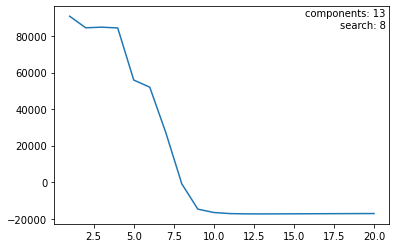

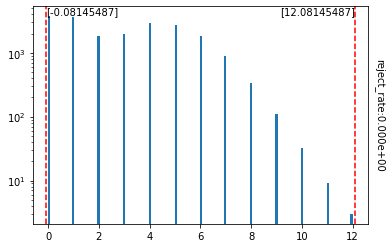

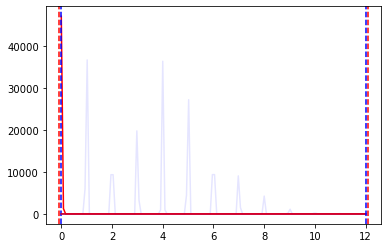

In [4]:
outlyer = OutlyerModel()
display(outlyer.fit_transform(y))
outlyer.plot()

以下、データバリエーション

# 正規分布3峰

In [5]:
y = np.random.normal(loc=10, scale=5, size=4000)
y = np.append(y, np.random.normal(loc=30, scale=5, size=3000))
y = np.append(y, np.random.normal(loc=50, scale=5, size=2000))

(array([-3.26792187]), array([62.71193573]), 0.0023333333333333335)

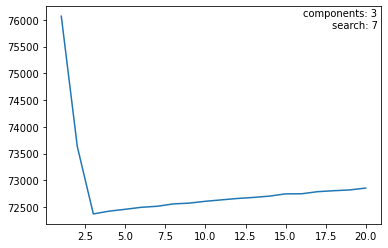

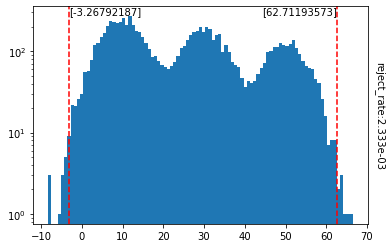

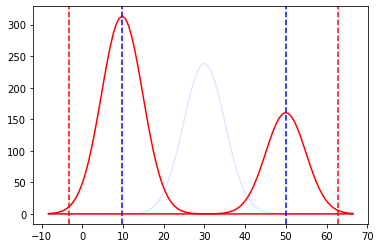

In [6]:
outlyer = OutlyerModel()
display(outlyer.fit_transform(y))
outlyer.plot()

In [7]:
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
y = df["petal length (cm)"].values

(array([1.0121168]), array([7.0267886]), 0.006666666666666667)

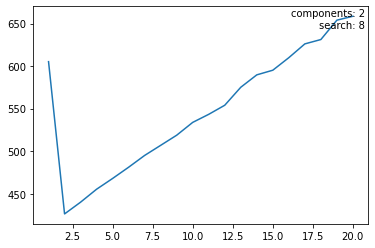

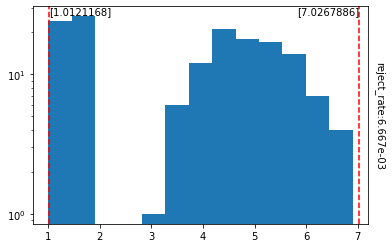

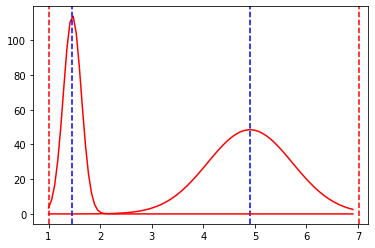

In [8]:
outlyer = OutlyerModel()
display(outlyer.fit_transform(y))
outlyer.plot()

# ポアソン分布

(array([-0.08145487]), array([6.08145487]), 7e-05)

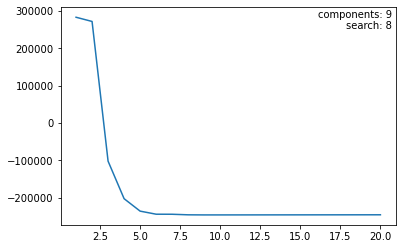

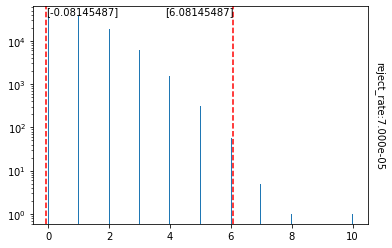

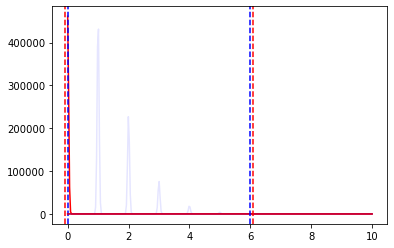

In [9]:
y = np.random.poisson(lam=1.0, size=100000)
y[0] = 10
outlyer = OutlyerModel()
display(outlyer.fit_transform(y))
outlyer.plot()

# ポアソンと正規分布混合

(array([-3.59065083]), array([11.2003436]), 0.00045454545454545455)

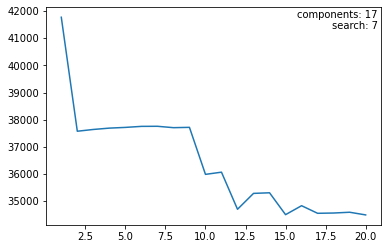

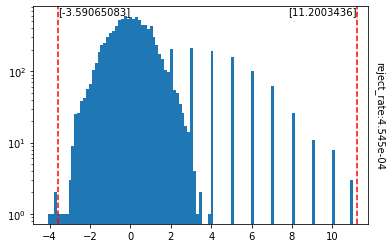

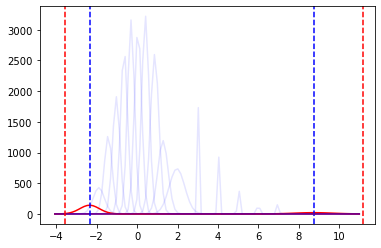

In [10]:
y = np.random.poisson(lam=4.0, size=1000)
y = np.append(y, np.random.normal(size=10000))
outlyer = OutlyerModel()
display(outlyer.fit_transform(y))
outlyer.plot()

# 整数一様分布

(array([3.54910742]), array([104.32935993]), 0.002)

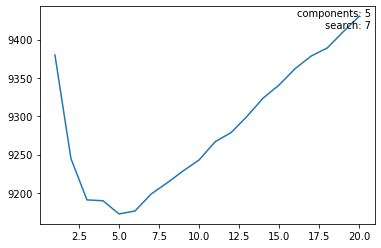

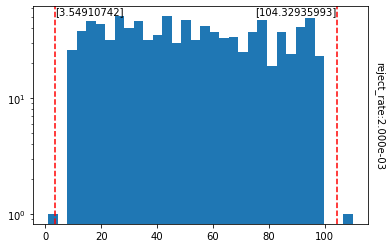

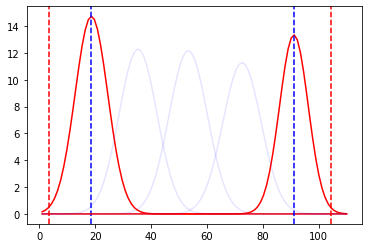

In [14]:
y = np.random.randint(10, 100, size=1000)
y[1] = 110
y[2] = 1
outlyer = OutlyerModel()
display(outlyer.fit_transform(y))
outlyer.plot()